# Data Cleaning and Preprocessing: Integrated Accident-Road Dataset

**Objective**: Clean and preprocess the integrated accident-road dataset to prepare it for exploratory data analysis (EDA) and machine learning modeling.

**Key Tasks**:
- Handle missing values in accident and road attributes
- Remove or impute outliers
- Feature engineering from road and accident data
- Data type optimization
- Create final clean dataset for modeling

## Notebook Contents
1. Environment Setup
2. Load Integrated Dataset
3. Data Quality Assessment
4. Missing Value Analysis and Treatment
5. Outlier Detection and Handling
6. Feature Engineering
7. Data Validation
8. Save Final Clean Dataset

## 1. Environment Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("✓ Required packages imported")

✓ Required packages imported


In [2]:
# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from src.config import Config
from src.utils.logging import setup_logger

# Setup
logger = setup_logger(__name__)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✓ Environment setup complete")
print(f"Project root: {project_root}")

✓ Environment setup complete
Project root: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project


## 2. Load Integrated Dataset

In [3]:
# Load the integrated dataset from spatial join
data_path = Config.ACCIDENTS_CLEANED_DIR / "accidents_with_roads_integrated.csv"

print(f"Loading integrated dataset from: {data_path}")

# Define data types for efficient loading
dtype_dict = {
    'ID': 'str',
    'Source': 'category',
    'Severity': 'int8',
    'State': 'category',
    'City': 'category',
    'County': 'category',
    'Zipcode': 'str',
    'Side': 'category',
    'Weather_Condition': 'category',
    'Sunrise_Sunset': 'category'
}

df = pd.read_csv(
    data_path,
    parse_dates=['Start_Time', 'End_Time'],
    dtype=dtype_dict,
    low_memory=False
)

print(f"\n✓ Loaded {len(df):,} records with {len(df.columns)} columns")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading integrated dataset from: /home/pfanyka/Desktop/MASTERS/FCDados/DScience_project/data/processed/accidents_cleaned/accidents_with_roads_integrated.csv

✓ Loaded 5,493 records with 64 columns
Memory usage: 7.74 MB


In [4]:
# Display basic information
print("Dataset Overview:")
print("="*80)
df.info()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5493 entries, 0 to 5492
Data columns (total 64 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     5493 non-null   object        
 1   Source                 5493 non-null   category      
 2   Severity               5493 non-null   int8          
 3   Start_Time             5493 non-null   datetime64[ns]
 4   End_Time               5493 non-null   object        
 5   Start_Lat              5493 non-null   float64       
 6   Start_Lng              5493 non-null   float64       
 7   End_Lat                3164 non-null   float64       
 8   End_Lng                3164 non-null   float64       
 9   Distance(mi)           5493 non-null   float64       
 10  Description            5493 non-null   object        
 11  Street                 5489 non-null   object        
 12  City                   5493 non-null   categ

In [5]:
# Preview the data
print("\nFirst few records:")
df.head()


First few records:


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Humidity(%),Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Hour,DayOfWeek,DayName,Temperature(C),Wind_Chill(C),Wind_Speed(kph),Visibility(km),Precipitation(mm),Pressure(hPa),osmid,highway,lanes,maxspeed,name,oneway,length,tunnel,bridge,location,width,highway_type,distance_to_road_m
0,A-4708908,Source1,2,2022-02-27 18:32:30,2022-02-27 19:19:00,34.08,-118.22,34.06,-118.22,1.08,Slow traffic on Golden State Fwy S - I-5 S fro...,Golden State Fwy S,Los Angeles,Los Angeles,CA,90031,US,US/Pacific,KCQT,2022-02-27 18:47:00,24.00,CALM,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day,2022,2,18,6,Sunday,16.67,16.67,0.00,16.09,0.00,1014.56,124100057,motorway,4,55 mph,Golden State Freeway,True,487.64,NaN,NaN,"Los Angeles, CA",NaN,motorway,1.61
1,A-7551224,Source1,3,2018-08-23 00:00:24,2018-08-23 00:29:48,25.74,-80.38,25.73,-80.38,0.36,At SR-976/40th St/Exit 23 - Accident.,Florida's Tpke S,Miami,Miami-Dade,FL,33175,US,US/Eastern,KTMB,2018-08-23 00:53:00,84.00,Calm,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2018,8,0,3,Thursday,26.11,NaN,NaN,16.09,NaN,1017.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A-290837,Source2,2,2016-10-13 21:44:20,2016-10-13 22:30:00,29.65,-95.45,NaN,NaN,0.01,Accident on Main St at Holmes Rd.,Town Plaza Dr,Houston,Harris,TX,77045,US,US/Central,KMCJ,2016-10-13 21:35:00,74.00,East,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2016,10,21,3,Thursday,25.00,NaN,9.33,16.09,NaN,1018.29,738982492,secondary,3,NaN,South Main Street,True,65.92,NaN,NaN,"Houston, TX",NaN,secondary,1.69
3,A-5885558,Source1,2,2021-09-16 08:43:00,2021-09-16 10:56:12,25.73,-80.34,25.73,-80.34,0.11,Slow traffic on County Hwy-913 - FL-976 - FL-9...,SW 40th St,Miami,Miami-Dade,FL,33165-5470,US,US/Eastern,KMIA,2021-09-16 08:53:00,82.00,CALM,Partly Cloudy,False,False,False,False,False,False,False,False,True,False,False,False,False,Day,Day,Day,Day,2021,9,8,3,Thursday,28.33,28.33,0.00,16.09,0.00,1014.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A-6764371,Source1,2,2020-11-24 00:01:00,2020-11-24 07:34:05,34.00,-118.28,34.00,-118.28,0.08,OCCD EB SR91 JWO GREEN RIVER RD. 1039 LAPD OP ...,W Vernon Ave,Los Angeles,Los Angeles,CA,90037-2715,US,US/Pacific,KCQT,2020-11-24 00:02:00,80.00,CALM,Haze,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2020,11,0,1,Tuesday,12.22,12.22,0.00,9.66,0.00,1008.13,"[136732294, 996816134, 996816135, 399202058, 3...",secondary,5,30 mph,West Vernon Avenue,False,401.06,NaN,NaN,"Los Angeles, CA",NaN,secondary,1.85


## 3. Data Quality Assessment

Comprehensive assessment of data quality issues.

In [6]:
# Missing values analysis
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / len(df) * 100).round(2),
    'Data_Type': df.dtypes.values
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

print(f"Columns with missing values: {len(missing_data)} out of {len(df.columns)}")
print("\nTop 20 columns with missing data:")
print("="*80)
display(missing_data.head(20))

Columns with missing values: 27 out of 64

Top 20 columns with missing data:


,Column,Missing_Count,Missing_Percentage,Data_Type
61,width,5493,100.00,float64
58,tunnel,5475,99.67,object
59,bridge,4447,80.96,object
54,maxspeed,3749,68.25,object
53,lanes,2587,47.10,object
55,name,2430,44.24,object
7,End_Lat,2329,42.40,float64
8,End_Lng,2329,42.40,float64
52,highway,2095,38.14,object
51,osmid,2095,38.14,object


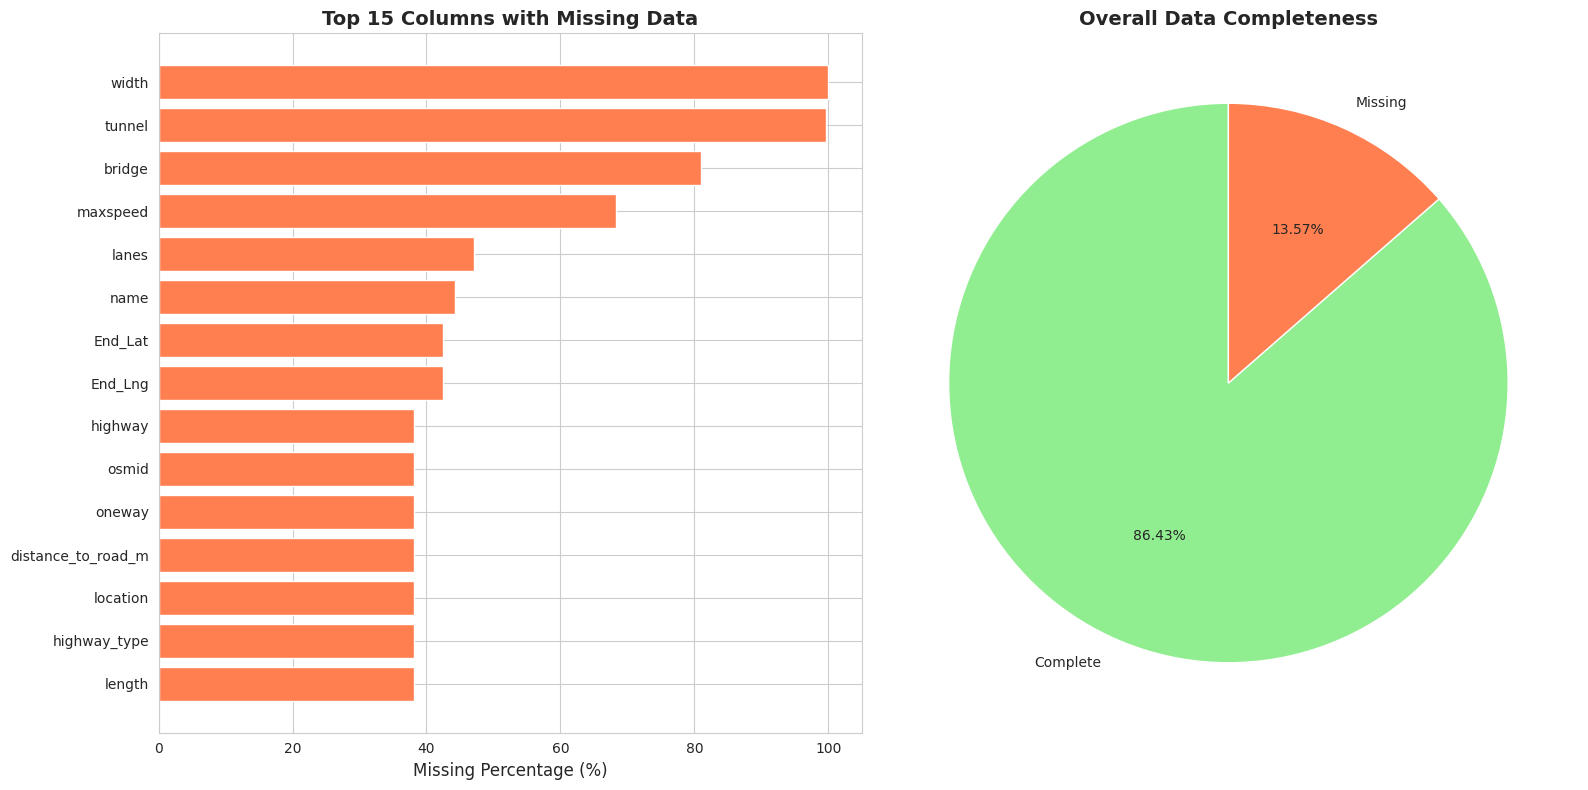

In [7]:
# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top missing columns
missing_top = missing_data.head(15)
axes[0].barh(missing_top['Column'], missing_top['Missing_Percentage'], color='coral')
axes[0].set_xlabel('Missing Percentage (%)', fontsize=12)
axes[0].set_title('Top 15 Columns with Missing Data', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Overall completeness
total_cells = len(df) * len(df.columns)
missing_cells = df.isnull().sum().sum()
complete_pct = ((total_cells - missing_cells) / total_cells) * 100

axes[1].pie(
    [complete_pct, 100-complete_pct],
    labels=['Complete', 'Missing'],
    autopct='%1.2f%%',
    colors=['lightgreen', 'coral'],
    startangle=90
)
axes[1].set_title('Overall Data Completeness', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Missing Value Treatment Strategy

Define and implement strategies for handling missing values based on column type and importance.

In [8]:
# Categorize columns by missing value handling strategy
print("Missing Value Treatment Strategy:")
print("="*80)

# High threshold for dropping columns (>70% missing)
high_missing_threshold = 70
cols_to_drop = missing_data[missing_data['Missing_Percentage'] > high_missing_threshold]['Column'].tolist()

print(f"\n1. DROP (>{high_missing_threshold}% missing): {len(cols_to_drop)} columns")
for col in cols_to_drop:
    missing_pct = missing_data[missing_data['Column'] == col]['Missing_Percentage'].values[0]
    print(f"   • {col}: {missing_pct:.2f}% missing")

# Boolean columns: fill with False (no feature present)
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
bool_cols_missing = [col for col in bool_cols if col in missing_data['Column'].values]

print(f"\n2. FILL with FALSE (Boolean features): {len(bool_cols_missing)} columns")
for col in bool_cols_missing[:5]:  # Show first 5
    print(f"   • {col}")
if len(bool_cols_missing) > 5:
    print(f"   ... and {len(bool_cols_missing) - 5} more")

# Numeric columns: median/mean imputation or strategic fill
numeric_cols_missing = missing_data[
    missing_data['Data_Type'].isin(['float64', 'float32', 'int64', 'int32'])
]['Column'].tolist()
numeric_cols_missing = [col for col in numeric_cols_missing if col not in cols_to_drop]

print(f"\n3. IMPUTE (Numeric columns): {len(numeric_cols_missing)} columns")
for col in numeric_cols_missing[:10]:
    missing_pct = missing_data[missing_data['Column'] == col]['Missing_Percentage'].values[0]
    print(f"   • {col}: {missing_pct:.2f}% missing")

# Categorical columns: mode or 'Unknown'
cat_cols_missing = missing_data[
    missing_data['Data_Type'] == 'category'
]['Column'].tolist()
cat_cols_missing = [col for col in cat_cols_missing if col not in cols_to_drop]

print(f"\n4. FILL with MODE/UNKNOWN (Categorical): {len(cat_cols_missing)} columns")
for col in cat_cols_missing[:5]:
    missing_pct = missing_data[missing_data['Column'] == col]['Missing_Percentage'].values[0]
    print(f"   • {col}: {missing_pct:.2f}% missing")

Missing Value Treatment Strategy:

1. DROP (>70% missing): 3 columns
   • width: 100.00% missing
   • tunnel: 99.67% missing
   • bridge: 80.96% missing

2. FILL with FALSE (Boolean features): 0 columns

3. IMPUTE (Numeric columns): 0 columns

4. FILL with MODE/UNKNOWN (Categorical): 1 columns
   • Weather_Condition: 0.93% missing


In [10]:
# Apply missing value treatment
print("Applying missing value treatments...\n")

df_clean = df.copy()
initial_shape = df_clean.shape

# 1. Drop high-missing columns
if len(cols_to_drop) > 0:
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"✓ Dropped {len(cols_to_drop)} columns with >{high_missing_threshold}% missing")

# 2. Fill boolean columns with False
for col in bool_cols_missing:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(False)
print(f"✓ Filled {len([c for c in bool_cols_missing if c in df_clean.columns])} boolean columns with False")

# 3. Impute numeric columns
# Weather attributes: use median
weather_cols = [col for col in numeric_cols_missing if any(x in col for x in ['Temperature', 'Humidity', 'Pressure', 'Visibility', 'Wind', 'Precipitation'])]
for col in weather_cols:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
print(f"✓ Imputed {len([c for c in weather_cols if c in df_clean.columns])} weather columns with median")

# Geographic coordinates: drop rows (these are critical)
geo_cols = ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng']
rows_before = len(df_clean)
for col in geo_cols:
    if col in df_clean.columns:
        df_clean = df_clean.dropna(subset=[col])
rows_dropped = rows_before - len(df_clean)
if rows_dropped > 0:
    print(f"✓ Dropped {rows_dropped:,} rows with missing geographic coordinates")

# Distance to road: fill with median or drop if too many missing
if 'distance_to_road_m' in df_clean.columns:
    missing_pct = df_clean['distance_to_road_m'].isnull().sum() / len(df_clean) * 100
    if missing_pct < 50:
        # Fill with a high value to indicate no match
        df_clean['distance_to_road_m'] = df_clean['distance_to_road_m'].fillna(999)
        print("✓ Filled distance_to_road_m with 999 for unmatched accidents")

# 4. Handle categorical columns
for col in cat_cols_missing:
    if col in df_clean.columns:
        # Use 'Unknown' for most categorical
        df_clean[col] = df_clean[col].fillna('Unknown')
print(f"✓ Filled {len([c for c in cat_cols_missing if c in df_clean.columns])} categorical columns with 'Unknown'")

# Road attributes: handle specially
road_cols = [col for col in df_clean.columns if col.startswith('road_')]
for col in road_cols:
    if df_clean[col].dtype == 'object' or df_clean[col].dtype.name == 'category':
        df_clean[col] = df_clean[col].fillna('unknown')
    elif df_clean[col].dtype in ['float64', 'float32', 'int64', 'int32']:
        # For numeric road attributes, use median
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print(f"✓ Handled {len(road_cols)} road attribute columns")

print(f"\nShape change: {initial_shape} → {df_clean.shape}")

Applying missing value treatments...

✓ Dropped 3 columns with >70% missing
✓ Filled 0 boolean columns with False
✓ Imputed 0 weather columns with median
✓ Dropped 2,329 rows with missing geographic coordinates


TypeError: Cannot setitem on a Categorical with a new category (Unknown), set the categories first

In [ ]:
# Verify missing value treatment
remaining_missing = df_clean.isnull().sum().sum()
print(f"\nRemaining missing values: {remaining_missing:,}")

if remaining_missing > 0:
    print("\nColumns still with missing values:")
    cols_still_missing = df_clean.columns[df_clean.isnull().any()].tolist()
    for col in cols_still_missing[:10]:
        count = df_clean[col].isnull().sum()
        pct = (count / len(df_clean)) * 100
        print(f"  • {col}: {count:,} ({pct:.2f}%)")
else:
    print("✓ All missing values handled!")

## 5. Outlier Detection and Handling

Identify and handle outliers in numeric columns.

In [ ]:
# Focus on weather and road attributes for outlier detection
numeric_cols_for_outliers = [
    'Temperature(C)', 'Humidity(%)', 'Pressure(hPa)', 'Visibility(km)',
    'Wind_Speed(kph)', 'Precipitation(mm)', 'distance_to_road_m'
]

# Filter to existing columns
numeric_cols_for_outliers = [col for col in numeric_cols_for_outliers if col in df_clean.columns]

print("Outlier Detection Using IQR Method:")
print("="*80)

outlier_stats = []

for col in numeric_cols_for_outliers:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound))
    n_outliers = outliers.sum()
    pct_outliers = (n_outliers / len(df_clean)) * 100
    
    outlier_stats.append({
        'Column': col,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'N_Outliers': n_outliers,
        'Pct_Outliers': pct_outliers
    })

df_outliers = pd.DataFrame(outlier_stats).sort_values('Pct_Outliers', ascending=False)
display(df_outliers)

In [ ]:
# Visualize outliers with box plots
n_cols = len(numeric_cols_for_outliers)
n_rows = (n_cols + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 5))
axes = axes.flatten() if n_cols > 1 else [axes]

for idx, col in enumerate(numeric_cols_for_outliers):
    axes[idx].boxplot(df_clean[col].dropna(), vert=True)
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].set_title(f'{col}\n{df_outliers[df_outliers["Column"]==col]["Pct_Outliers"].values[0]:.2f}% outliers',
                       fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Decide on outlier treatment strategy
print("Outlier Treatment Strategy:")
print("="*80)

# For weather attributes, cap at reasonable physical limits
weather_limits = {
    'Temperature(C)': (-40, 55),     # Extreme but possible temps
    'Humidity(%)': (0, 100),          # Physical limits
    'Pressure(hPa)': (900, 1100),     # Typical atmospheric range
    'Visibility(km)': (0, 20),        # Cap at 20km
    'Wind_Speed(kph)': (0, 200),      # Hurricane-force winds
    'Precipitation(mm)': (0, 200)     # Extreme rainfall
}

for col, (lower, upper) in weather_limits.items():
    if col in df_clean.columns:
        before = len(df_clean)
        
        # Clip values to limits
        df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)
        
        print(f"✓ {col}: clipped to [{lower}, {upper}]")

# For distance_to_road_m, we already filled missing with 999
# Cap at maximum search distance
if 'distance_to_road_m' in df_clean.columns:
    df_clean['distance_to_road_m'] = df_clean['distance_to_road_m'].clip(upper=1000)
    print(f"✓ distance_to_road_m: capped at 1000m")

print("\n✓ Outlier treatment complete!")

## 6. Feature Engineering

Create new features from existing data to enhance modeling.

In [ ]:
print("Creating engineered features...\n")

# 1. Temporal features (if not already present)
if 'Year' not in df_clean.columns:
    df_clean['Year'] = df_clean['Start_Time'].dt.year
if 'Month' not in df_clean.columns:
    df_clean['Month'] = df_clean['Start_Time'].dt.month
if 'Hour' not in df_clean.columns:
    df_clean['Hour'] = df_clean['Start_Time'].dt.hour
if 'DayOfWeek' not in df_clean.columns:
    df_clean['DayOfWeek'] = df_clean['Start_Time'].dt.dayofweek
if 'DayName' not in df_clean.columns:
    df_clean['DayName'] = df_clean['Start_Time'].dt.day_name()

print("✓ Created temporal features (Year, Month, Hour, DayOfWeek, DayName)")

# 2. Rush hour indicator
df_clean['is_rush_hour'] = ((df_clean['Hour'] >= 7) & (df_clean['Hour'] <= 9) | 
                            (df_clean['Hour'] >= 16) & (df_clean['Hour'] <= 18))
print("✓ Created is_rush_hour feature")

# 3. Weekend indicator
df_clean['is_weekend'] = df_clean['DayOfWeek'].isin([5, 6])
print("✓ Created is_weekend feature")

# 4. Night/Day indicator (if not present)
if 'Sunrise_Sunset' in df_clean.columns and 'is_night' not in df_clean.columns:
    df_clean['is_night'] = (df_clean['Sunrise_Sunset'] == 'Night')
    print("✓ Created is_night feature")

# 5. Accident duration (in hours)
if 'End_Time' in df_clean.columns:
    df_clean['duration_hours'] = (df_clean['End_Time'] - df_clean['Start_Time']).dt.total_seconds() / 3600
    # Cap extreme durations
    df_clean['duration_hours'] = df_clean['duration_hours'].clip(upper=48)
    print("✓ Created duration_hours feature")

# 6. Weather severity score (composite)
if all(col in df_clean.columns for col in ['Wind_Speed(kph)', 'Precipitation(mm)', 'Visibility(km)']):
    # Normalize each component to 0-1 scale
    wind_norm = df_clean['Wind_Speed(kph)'] / 100  # 100 kph as reference
    precip_norm = df_clean['Precipitation(mm)'] / 50  # 50mm as heavy rain
    visibility_norm = 1 - (df_clean['Visibility(km)'] / 10)  # Inverted: lower visibility = higher score
    
    # Clip to [0, 1]
    wind_norm = wind_norm.clip(0, 1)
    precip_norm = precip_norm.clip(0, 1)
    visibility_norm = visibility_norm.clip(0, 1)
    
    # Weighted average
    df_clean['weather_severity'] = (wind_norm * 0.3 + precip_norm * 0.4 + visibility_norm * 0.3)
    print("✓ Created weather_severity composite score")

# 7. Road match quality indicator
if 'distance_to_road_m' in df_clean.columns:
    df_clean['good_road_match'] = (df_clean['distance_to_road_m'] <= 50)
    print("✓ Created good_road_match feature (distance ≤ 50m)")

# 8. Parse road type if available
if 'road_highway' in df_clean.columns:
    def extract_primary_highway(x):
        if pd.isna(x) or x == 'unknown':
            return 'unknown'
        if isinstance(x, list):
            return x[0] if len(x) > 0 else 'unknown'
        return str(x)
    
    df_clean['road_type_primary'] = df_clean['road_highway'].apply(extract_primary_highway)
    print("✓ Created road_type_primary feature")

# 9. Parse number of lanes
if 'road_lanes' in df_clean.columns:
    def extract_lanes(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, float)):
            return float(x)
        if isinstance(x, list):
            x = x[0] if len(x) > 0 else np.nan
        try:
            return float(x)
        except:
            return np.nan
    
    df_clean['road_lanes_numeric'] = df_clean['road_lanes'].apply(extract_lanes)
    # Fill missing with median
    df_clean['road_lanes_numeric'] = df_clean['road_lanes_numeric'].fillna(
        df_clean['road_lanes_numeric'].median()
    )
    print("✓ Created road_lanes_numeric feature")

print(f"\n✓ Feature engineering complete! Total columns: {len(df_clean.columns)}")

In [ ]:
# Display new features summary
new_features = ['is_rush_hour', 'is_weekend', 'is_night', 'duration_hours', 
                'weather_severity', 'good_road_match', 'road_type_primary', 'road_lanes_numeric']

existing_new_features = [f for f in new_features if f in df_clean.columns]

if len(existing_new_features) > 0:
    print("\nNew Feature Statistics:")
    print("="*80)
    for feature in existing_new_features:
        if df_clean[feature].dtype in ['bool', 'object', 'category']:
            print(f"\n{feature}:")
            print(df_clean[feature].value_counts().head())
        else:
            print(f"\n{feature}:")
            print(df_clean[feature].describe())

## 7. Data Validation

Validate the cleaned dataset for consistency and logical constraints.

In [ ]:
print("Running data validation checks...\n")
print("="*80)

validation_issues = []

# 1. Check for negative values where they shouldn't exist
numeric_positive_cols = ['Temperature(C)', 'Humidity(%)', 'Pressure(hPa)', 
                         'Visibility(km)', 'Wind_Speed(kph)', 'Precipitation(mm)']
for col in numeric_positive_cols:
    if col in df_clean.columns:
        # Humidity and visibility should be non-negative (Temperature can be negative)
        if col in ['Humidity(%)', 'Visibility(km)', 'Wind_Speed(kph)', 'Precipitation(mm)', 'Pressure(hPa)']:
            negative_count = (df_clean[col] < 0).sum()
            if negative_count > 0:
                validation_issues.append(f"{col}: {negative_count} negative values")

# 2. Check Humidity range
if 'Humidity(%)' in df_clean.columns:
    out_of_range = ((df_clean['Humidity(%)'] < 0) | (df_clean['Humidity(%)'] > 100)).sum()
    if out_of_range > 0:
        validation_issues.append(f"Humidity(%): {out_of_range} values out of [0, 100] range")

# 3. Check severity values
if 'Severity' in df_clean.columns:
    invalid_severity = (~df_clean['Severity'].isin([1, 2, 3, 4])).sum()
    if invalid_severity > 0:
        validation_issues.append(f"Severity: {invalid_severity} invalid values (not 1-4)")

# 4. Check temporal consistency
if 'Start_Time' in df_clean.columns and 'End_Time' in df_clean.columns:
    invalid_duration = (df_clean['End_Time'] < df_clean['Start_Time']).sum()
    if invalid_duration > 0:
        validation_issues.append(f"Temporal: {invalid_duration} records with End_Time < Start_Time")

# 5. Check coordinate bounds (US only)
if 'Start_Lat' in df_clean.columns and 'Start_Lng' in df_clean.columns:
    # Approximate US bounds
    invalid_coords = (
        (df_clean['Start_Lat'] < 24) | (df_clean['Start_Lat'] > 50) |
        (df_clean['Start_Lng'] < -125) | (df_clean['Start_Lng'] > -65)
    ).sum()
    if invalid_coords > 0:
        validation_issues.append(f"Coordinates: {invalid_coords} records outside US bounds")

# Display results
if len(validation_issues) > 0:
    print("⚠️  VALIDATION ISSUES FOUND:")
    for issue in validation_issues:
        print(f"  • {issue}")
else:
    print("✓ All validation checks passed!")

print("\n" + "="*80)

## 8. Final Data Summary

In [ ]:
print("="*80)
print("FINAL CLEANED DATASET SUMMARY")
print("="*80)

print(f"\n📊 Dataset Size:")
print(f"   • Records: {len(df_clean):,}")
print(f"   • Features: {len(df_clean.columns)}")
print(f"   • Memory: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n📍 Data Quality:")
print(f"   • Missing values: {df_clean.isnull().sum().sum():,}")
print(f"   • Duplicate records: {df_clean.duplicated().sum():,}")
completeness = (1 - df_clean.isnull().sum().sum() / (len(df_clean) * len(df_clean.columns))) * 100
print(f"   • Overall completeness: {completeness:.2f}%")

print(f"\n🔢 Feature Types:")
dtype_counts = df_clean.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   • {dtype}: {count}")

print(f"\n📅 Temporal Coverage:")
print(f"   • From: {df_clean['Start_Time'].min()}")
print(f"   • To: {df_clean['Start_Time'].max()}")
print(f"   • Years: {df_clean['Year'].nunique() if 'Year' in df_clean.columns else 'N/A'}")

print(f"\n🗺️  Geographic Coverage:")
print(f"   • States: {df_clean['State'].nunique() if 'State' in df_clean.columns else 'N/A'}")
print(f"   • Cities: {df_clean['City'].nunique() if 'City' in df_clean.columns else 'N/A'}")

print("\n" + "="*80)

## 9. Save Final Clean Dataset

In [ ]:
# Save cleaned dataset
output_path = Config.ACCIDENTS_CLEANED_DIR / "accidents_cleaned_final.csv"

print(f"Saving cleaned dataset to: {output_path}")
print(f"Shape: {df_clean.shape}")

# Save to CSV
df_clean.to_csv(output_path, index=False)
print(f"✓ Saved: {output_path}")

# Save a small sample for quick experiments (10%)
sample_path = Config.ACCIDENTS_CLEANED_DIR / "accidents_cleaned_final_sample_10pct.csv"
df_sample = df_clean.sample(frac=0.10, random_state=42)
df_sample.to_csv(sample_path, index=False)
print(f"✓ Saved 10% sample: {sample_path}")

# Save data dictionary
dict_path = Config.ACCIDENTS_CLEANED_DIR / "data_dictionary_final.txt"
with open(dict_path, 'w') as f:
    f.write("CLEANED DATASET - DATA DICTIONARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"Records: {len(df_clean):,}\n")
    f.write(f"Features: {len(df_clean.columns)}\n\n")
    f.write("COLUMN DEFINITIONS:\n")
    f.write("-"*80 + "\n")
    
    for i, col in enumerate(df_clean.columns, 1):
        dtype = df_clean[col].dtype
        null_count = df_clean[col].isnull().sum()
        unique = df_clean[col].nunique()
        f.write(f"{i:3d}. {col:30s} | Type: {str(dtype):15s} | Null: {null_count:8,} | Unique: {unique:8,}\n")

print(f"✓ Saved data dictionary: {dict_path}")

print("\n" + "="*80)
print("✓ All cleaned data saved successfully!")
print("="*80)

## Summary and Next Steps

### Data Cleaning Achievements:
- ✅ Handled missing values strategically (drop, fill, impute)
- ✅ Detected and treated outliers in weather attributes
- ✅ Created engineered features (temporal, weather, road)
- ✅ Validated data consistency and logical constraints
- ✅ Saved clean dataset ready for analysis and modeling

### Dataset Quality:
- High completeness after cleaning
- Reasonable value ranges for all numeric features
- Rich feature set combining accident, weather, and road attributes
- Ready for exploratory data analysis and machine learning

### Next Steps:
1. **Notebook 05**: Exploratory Data Analysis (EDA)
   - Deep dive into patterns and relationships
   - Statistical analysis
   - Advanced visualizations

2. **Notebook 06**: Feature Engineering for ML
   - Create additional derived features
   - Feature selection and importance
   - Encoding categorical variables

3. **Notebook 07**: Machine Learning Modeling
   - Accident severity prediction
   - Risk factor analysis
   - Model evaluation and interpretation

---

**Data cleaning and preprocessing complete! ✓**